# Astronaut Deconvolution - Ringing Artifacts

This example demonstrates deconvolution of a single 2D image in the style of this [Scikit-Image](http://scikit-image.org/docs/dev/auto_examples/filters/plot_deconvolution.html) example as well as how to alleviate (at least partially) the ringing artifacts around the edges of the result.  

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from skimage import color as sk_color
from skimage import data as sk_data
from flowdec import data as fd_data
from flowdec import restoration as fd_restoration

CPU times: user 29.8 s, sys: 271 ms, total: 30 s
Wall time: 29.3 s


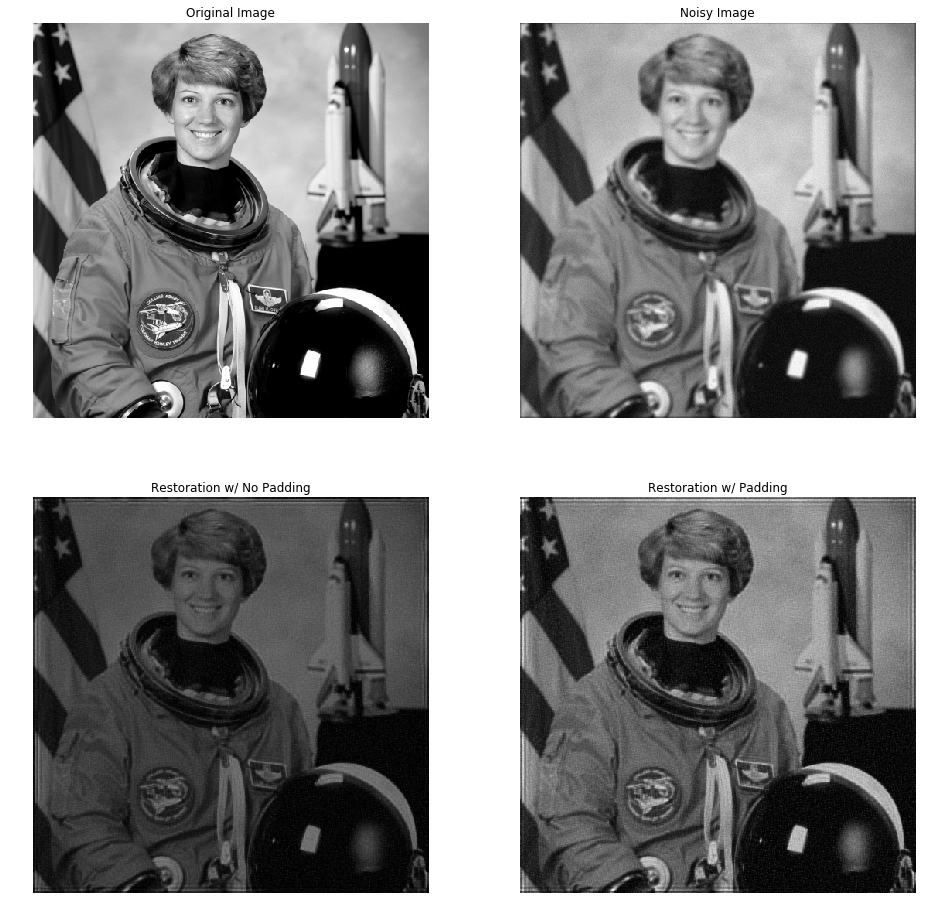

In [98]:
%%time 

# Load skimage "Astro" 2D image and generate a fake PSF
img = sk_color.rgb2gray(sk_data.astronaut())
psf = np.ones((5, 5)) / 25

# Add blur and noise to image
np.random.seed(1)
img_blur = fftconvolve(img, psf, 'same') + (np.random.poisson(lam=25, size=img.shape) - 10) / 255.

# Wrap image and PSF in "Acqusition" instance, which aids in doing comparisons and running
# operations on all data associated with a data acquisition
acquisition = fd_data.Acquisition(data=img_blur, kernel=psf)

# Run deconvolution using default arguments (will default to adding no padding to image
# as its dimensions are already powers of 2)
img_decon = fd_restoration.richardson_lucy(acquisition, niter=30)

# Run the deconvolution again but with more care to specify how padding is done
img_decon_pad = fd_restoration.richardson_lucy(
    acquisition, niter=30, 
    # Force an extra 64 pixels along each dimension
    pad_mode='none',  # Instead of default 'log2'    
    pad_min=[64, 64]
)

# Plot results and original
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax = ax.ravel()
plt.gray()

for a in ax:
       a.axis('off')

ax[0].imshow(img)
ax[0].set_title('Original Image')

ax[1].imshow(img_blur)
ax[1].set_title('Noisy Image')

ax[2].imshow(img_decon)
ax[2].set_title('Restoration w/ No Padding')

ax[3].imshow(img_decon_pad)
ax[3].set_title('Restoration w/ Padding')

It is difficult to see exactly how padding has effected the extreme values in the results above, but clearly there is something going on with how much lower the intensity of the result with no padding appears to be.  This is because the extreme values around the edges of each restoration are quite different, something that can be more easily seen by looking at the tails of the distributions of the pixel intensities:

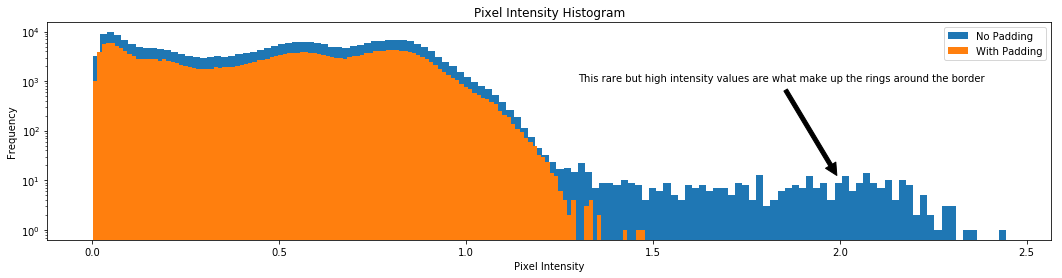

In [106]:
plt.hist(img_decon.ravel(), log=True, bins=128, label='No Padding')
plt.hist(img_decon_pad.ravel(), log=True, bins=128, label='With Padding')
plt.gcf().set_size_inches(18, 4)
ax = plt.gca()
annotation = 'This rare but high intensity values are what make up the rings around the border'
ax.annotate(annotation, xy=(2, 10), xytext=(1.3, 1000), arrowprops=dict(facecolor='black', shrink=0.05),)
ax.set_title('Pixel Intensity Histogram')
ax.set_xlabel('Pixel Intensity')
ax.set_ylabel('Frequency')
plt.legend()
None